In [1]:
from __future__ import division
from __future__ import print_function

import sys, os, gc
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
SEED = 14

Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10
eps=0.3

In [3]:
#Load model from disk
model_name = 'MNIST'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 50
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Total Model Params: 3330314
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.test_data, model.test_labels)[1]))


6055/6055 [==============================] - 1s 224us/step
Model Accuracy: 0.99306


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [6]:
num_test_samples_per_class =100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [7]:
#Pick target labels for CW
cw_tars = np.zeros_like(model.test_labels[test_indices])
classes = np.arange(num_classes)
np.random.seed(SEED)
for i, idx in enumerate(test_indices):
    label = np.argmax(model.test_labels[idx])
    classes = np.arange(num_classes)
    classes = np.delete(classes, label)
    mod_label = np.random.choice(classes, 1)[0]
    cw_tars[i, mod_label] = 1

In [8]:
#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=cw_tars,seed=SEED, perturbation='CW', targeted=True, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF', nb_candidate=num_classes)
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=cw_tars,seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    


Loaded model from disk


In [10]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM: %.5f' % (model.model.evaluate(fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-A: %.5f' % (model.model.evaluate(bim_a_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-B: %.5f' % (model.model.evaluate(bim_b_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW: %.5f' % (model.model.evaluate(cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy DF: %.5f' % (model.model.evaluate(df_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 197us/step
Model Accuracy REG: 0.99500
1000/1000 [==============================] - 0s 154us/step
Model Accuracy FGSM: 0.09000
1000/1000 [==============================] - 0s 139us/step
Model Accuracy BIM-A: 0.00500
1000/1000 [==============================] - 0s 140us/step
Model Accuracy BIM-B: 0.00500
1000/1000 [==============================] - 0s 133us/step
Model Accuracy CW: 0.00400
1000/1000 [==============================] - 0s 129us/step
Model Accuracy DF: 0.00400
1000/1000 [==============================] - 0s 131us/step
Model Accuracy JSMA: 0.02100


Regular: 


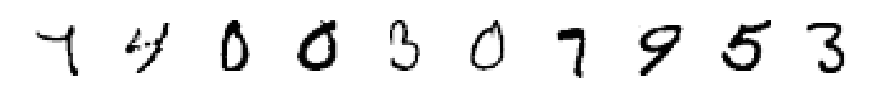

FGSM: 


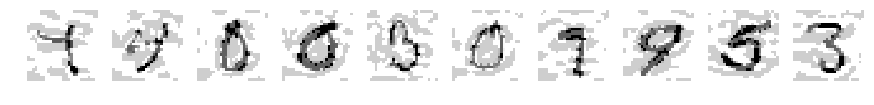

BIM-A: 


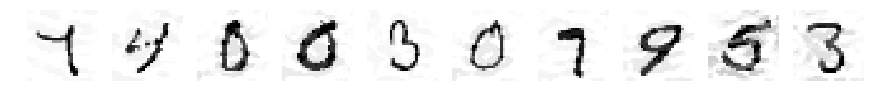

BIM-B: 


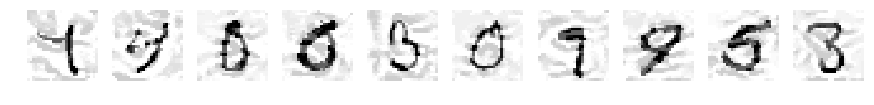

CW: 


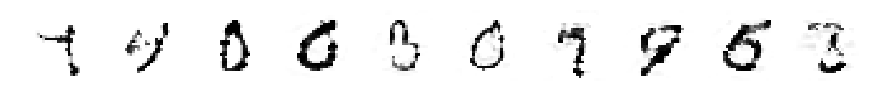

DF: 


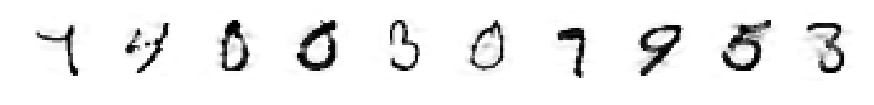

JSMA: 


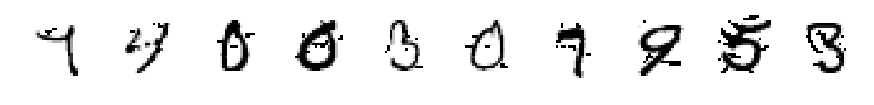

In [11]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-cifar2')
print ('FGSM: ')
visualize(fgsm_data[x_vis].reshape(-1,*input_shape), 10, '../figures/fgsm-cifar2')
print ('BIM-A: ')
visualize(bim_a_data[x_vis].reshape(-1,*input_shape), 10, '../figures/bim-a-cifar2')
print ('BIM-B: ')
visualize(bim_b_data[x_vis].reshape(-1,*input_shape), 10, '../figures/bim-b-cifar2')
print ('CW: ')
visualize(cw_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cw-cifar2')
print ('DF: ')
visualize(df_data[x_vis].reshape(-1,*input_shape), 10, '../figures/df-cifar2')
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-cifar2')

In [12]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
fgsm_labels = preds_to_labels(fgsm_preds)
bim_a_labels = preds_to_labels(bim_a_preds)
bim_b_labels = preds_to_labels(bim_b_preds)
cw_labels = preds_to_labels(cw_preds)
df_labels = preds_to_labels(df_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
fgsm_idx = np.where(np.argmax(fgsm_preds, axis=1) != true_preds)[0]
bim_a_idx = np.where(np.argmax(bim_a_preds, axis=1) != true_preds)[0]
bim_b_idx = np.where(np.argmax(bim_b_preds, axis=1) != true_preds)[0]
cw_idx = np.where(np.argmax(cw_preds, axis=1) != true_preds)[0]
df_idx = np.where(np.argmax(df_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
fgsm_data_fil = fgsm_data[fgsm_idx]
bim_a_data_fil = bim_a_data[bim_a_idx]
bim_b_data_fil = bim_b_data[bim_b_idx]
cw_data_fil = cw_data[cw_idx]
df_data_fil = df_data[df_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
fgsm_labels_fil = fgsm_labels[fgsm_idx]
bim_a_labels_fil = bim_a_labels[bim_a_idx]
bim_b_labels_fil = bim_b_labels[bim_b_idx]
cw_labels_fil = cw_labels[cw_idx]
df_labels_fil = df_labels[df_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [13]:
#Get distortion 
print ('FGSM: %.5f' % (avg_l2_dist(reg_data[fgsm_idx], fgsm_data_fil)))
print ('BIM-A: %.5f' % (avg_l2_dist(reg_data[bim_a_idx], bim_a_data_fil)))
print ('BIM-B: %.5f' % (avg_l2_dist(reg_data[bim_b_idx], bim_b_data_fil)))
print ('CW: %.5f' % (avg_l2_dist(reg_data[cw_idx], cw_data_fil)))
print ('DF: %.5f' % (avg_l2_dist(reg_data[df_idx], df_data_fil)))
print ('JSMA: %.5f' % (avg_l2_dist(reg_data[jsma_idx], jsma_data_fil)))

FGSM: 5.74208
BIM-A: 2.49870
BIM-B: 4.62698
CW: 3.64066
DF: 1.66336
JSMA: 4.69179


In [14]:
#Get cosine similarity and norms
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)
grads_train = normalize(grads_train)
grads_reg_norms, cos_sim_reg = norms_and_cos(model, reg_data, reg_labels, grads_train)
grads_fgsm_norms, cos_sim_fgsm =norms_and_cos(model, fgsm_data_fil, fgsm_labels_fil, grads_train)
grads_bim_a_norms, cos_sim_bim_a = norms_and_cos(model, bim_a_data_fil, bim_a_labels_fil, grads_train)
grads_bim_b_norms , cos_sim_bim_b= norms_and_cos(model, bim_b_data_fil, bim_b_labels_fil, grads_train)
grads_cw_norms, cos_sim_cw = norms_and_cos(model, cw_data_fil, cw_labels_fil, grads_train)
grads_df_norms, cos_sim_df = norms_and_cos(model, df_data_fil, df_labels_fil, grads_train)
grads_jsma_norms, cos_sim_jsma = norms_and_cos(model, jsma_data_fil, jsma_labels_fil, grads_train)

../models/util.py:81: RuntimeWarning: invalid value encountered in sqrt
  norms = np.sqrt(np.dot(grads, grads.T)).diagonal()


**LOGISTIC REGRESSION FOR GREYBOX**

In [15]:
#Train a logistic regression classifier on the data. We only train on gray box attack points. 
#Due to lack of data (computationally expensive to compute attack points), we use 95% of data to train and 5% to test

#Select training and test indices
np.random.seed(SEED)
train_pct = .95
reg_train_idx = np.random.choice(np.arange(num_test_samples), int(train_pct*num_test_samples), replace=False)
reg_test_idx = get_test_from_train_idx(np.arange(num_test_samples), reg_train_idx)
fgsm_train_idx = np.random.choice(np.arange(len(fgsm_idx)), int(len(fgsm_idx)*train_pct), replace=False)
fgsm_test_idx = get_test_from_train_idx(np.arange(len(fgsm_idx)), fgsm_train_idx)
bim_a_train_idx = np.random.choice(np.arange(len(bim_a_idx)), int(len(bim_a_idx)*train_pct), replace=False)
bim_a_test_idx = get_test_from_train_idx(np.arange(len(bim_a_idx)), bim_a_train_idx)
bim_b_train_idx =np.random.choice(np.arange(len(bim_b_idx)), int(len(bim_b_idx)*train_pct), replace=False)
bim_b_test_idx = get_test_from_train_idx(np.arange(len(bim_b_idx)), bim_b_train_idx)
jsma_train_idx =np.random.choice(np.arange(len(jsma_idx)), int(len(jsma_idx)*train_pct), replace=False)
jsma_test_idx = get_test_from_train_idx(np.arange(len(jsma_idx)), jsma_train_idx)
cw_train_idx = np.random.choice(np.arange(len(cw_idx)), int(len(cw_idx)*train_pct), replace=False)
cw_test_idx = get_test_from_train_idx(np.arange(len(cw_idx)), cw_train_idx)
df_train_idx = np.random.choice(np.arange(len(df_idx)), int(len(df_idx)*train_pct), replace=False)
df_test_idx = get_test_from_train_idx(np.arange(len(df_idx)), df_train_idx)



# Set up training and test data for logistic regression
train_data = np.concatenate((cos_sim_reg[reg_train_idx], 
                             cos_sim_fgsm[fgsm_train_idx],
                             cos_sim_bim_a[bim_a_train_idx],
                             cos_sim_bim_b[bim_b_train_idx], 
                             cos_sim_jsma[jsma_train_idx], 
                             cos_sim_cw[cw_train_idx], 
                             cos_sim_df[df_train_idx]),axis=0)
train_labels = np.concatenate((np.zeros(len(reg_train_idx)), 
                               np.ones(len(fgsm_train_idx)),
                               np.ones(len(bim_a_train_idx)),
                               np.ones(len(bim_b_train_idx)),
                               np.ones(len(jsma_train_idx)),
                               np.ones(len(cw_train_idx)),
                               np.ones(len(df_train_idx))),axis=0)

test_data = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_fgsm[fgsm_test_idx],
                             cos_sim_bim_a[bim_a_test_idx],
                             cos_sim_bim_b[bim_b_test_idx], 
                             cos_sim_jsma[jsma_test_idx], 
                             cos_sim_cw[cw_test_idx], 
                             cos_sim_df[df_test_idx]),axis=0)

test_labels = np.concatenate((np.zeros(len(reg_test_idx)), 
                               np.ones(len(fgsm_test_idx)),
                               np.ones(len(bim_a_test_idx)),
                               np.ones(len(bim_b_test_idx)),
                               np.ones(len(jsma_test_idx)),
                               np.ones(len(cw_test_idx)),
                               np.ones(len(df_test_idx))),axis=0)

In [16]:
#Leave one out cross validation
#train_data = np.concatenate((cos_sim_reg[reg_train_idx],
#                             cos_sim_fgsm,
#                             cos_sim_bim_a, 
#                             cos_sim_bim_b, 
#                             cos_sim_jsma, 
#                             cos_sim_cw),axis=0)
#train_labels = np.concatenate((np.zeros(len(reg_train_idx)), 
#                               np.ones(len(cos_sim_fgsm)),
#                               np.ones(len(cos_sim_bim_a)),
#                               np.ones(len(cos_sim_bim_b)),
#                               np.ones(len(cos_sim_jsma)),
#                               np.ones(len(cos_sim_cw))),axis=0)

#test_data = np.concatenate((cos_sim_reg[reg_test_idx], 
#                             cos_sim_df),axis=0)

#test_labels = np.concatenate((np.zeros(len(reg_test_idx)), 
#                               np.ones(len(cos_sim_df))),axis=0)
#Fit the data
#logreg = linear_model.LogisticRegression(C=1e5)
#logreg.fit(train_data, train_labels)


#Get Total accuracy
#total_acc = logreg.score(test_data, test_labels)

#print ('TOTAL Detection Acc: %.5f' %(total_acc))



In [17]:
#Fit the data
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_data, train_labels)

#Get Accuracy for each attack type
fgsm_acc = logreg.score(cos_sim_fgsm[fgsm_test_idx], np.ones(len(fgsm_test_idx)))
bim_a_acc = logreg.score(cos_sim_bim_a[bim_a_test_idx], np.ones(len(bim_a_test_idx)))
bim_b_acc = logreg.score(cos_sim_bim_b[bim_b_test_idx], np.ones(len(bim_b_test_idx)))
jsma_acc = logreg.score(cos_sim_jsma[jsma_test_idx], np.ones(len(jsma_test_idx)))
cw_acc = logreg.score(cos_sim_cw[cw_test_idx], np.ones(len(cw_test_idx)))
df_acc = logreg.score(cos_sim_df[df_test_idx], np.ones(len(df_test_idx)))

#Get Total accuracy
total_acc = logreg.score(test_data, test_labels)

print ('FGSM Detection Acc: %.5f' % (fgsm_acc))
print ('BIM-A Detection Acc: %.5f' % (bim_a_acc))
print ('BIM-B Detection Acc: %.5f' % (bim_b_acc))
print ('JSMA Detection Acc: %.5f' % (jsma_acc))
print ('CW Detection Acc: %.5f' % (cw_acc))
print ('DF Detection Acc: %.5f' % (df_acc))
print ('TOTAL Detection Acc: %.5f' %(total_acc))


FGSM Detection Acc: 0.97826
BIM-A Detection Acc: 1.00000
BIM-B Detection Acc: 0.98000
JSMA Detection Acc: 1.00000
CW Detection Acc: 1.00000
DF Detection Acc: 1.00000
TOTAL Detection Acc: 0.99420


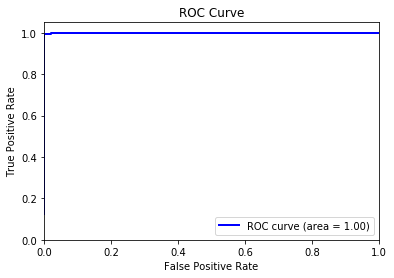

In [18]:
#Plot ROC for the entire test dataset
probs = logreg.predict_proba(test_data)
fpr, tpr, _ = roc_curve(test_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot all ROC curves
plt.figure()
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='blue', linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('mnist.eps', format='eps', dpi=1000)
plt.show()


**THRESHOLDING FOR GREYBOX**

In [19]:
#Ratio of perturbed samples having cos sim greater
print ('FGSM:  %.4f' % ( comp_cos(cos_sim_fgsm, cos_sim_reg[fgsm_idx])))
print ('BIM-A:  %.4f' % ( comp_cos(cos_sim_bim_a, cos_sim_reg[bim_a_idx])))
print ('BIM-B:  %.4f' % ( comp_cos(cos_sim_bim_b, cos_sim_reg[bim_b_idx])))
print ('CW: %.4f' % ( comp_cos(cos_sim_cw, cos_sim_reg[cw_idx])))
print ('DF: %.4f' % ( comp_cos(cos_sim_df, cos_sim_reg[df_idx])))
print ('JSMA: %.4f' % ( comp_cos(cos_sim_jsma, cos_sim_reg[jsma_idx])))

FGSM:  0.0725
BIM-A:  0.0342
BIM-B:  0.0774
CW: 0.0261
DF: 0.0211
JSMA: 0.0163


In [20]:
#Ratio of perturbed samples having norm greater
print ('FGSM:  %.4f' % ( comp_norm(grads_fgsm_norms, grads_reg_norms[fgsm_idx])))
print ('BIM-A:  %.4f' % ( comp_norm(grads_bim_a_norms, grads_reg_norms[bim_a_idx])))
print ('BIM-B:  %.4f' % ( comp_norm(grads_bim_b_norms, grads_reg_norms[bim_b_idx])))
print ('CW: %.4f' % ( comp_norm(grads_cw_norms, grads_reg_norms[cw_idx])))
print ('DF: %.4f' % ( comp_norm(grads_df_norms, grads_reg_norms[df_idx])))
print ('JSMA: %.4f' % ( comp_norm(grads_jsma_norms, grads_reg_norms[jsma_idx])))

FGSM:  0.9538
BIM-A:  0.9879
BIM-B:  0.6392
CW: 0.9980
DF: 0.9990
JSMA: 0.9928


In [21]:
#Separate Using Cos Sim
eta = 0.7
print ('Regular: %.4f' % ( greater_cos(cos_sim_reg, eta)))
print ('FGSM:  %.4f' % ( greater_cos(cos_sim_fgsm, eta)))
print ('BIM-A:  %.4f' % ( greater_cos(cos_sim_bim_a, eta)))
print ('BIM-B:  %.4f' % ( greater_cos(cos_sim_bim_b, eta)))
print ('CW: %.4f' % ( greater_cos(cos_sim_cw, eta)))
print ('DF: %.4f' % ( greater_cos(cos_sim_df, eta)))
print ('JSMA: %.4f' % ( greater_cos(cos_sim_jsma, eta)))

Regular: 0.8650
FGSM:  0.1791
BIM-A:  0.0573
BIM-B:  0.2241
CW: 0.0502
DF: 0.0181
JSMA: 0.0266


In [22]:
#Separate using just norm
gamma = .02
print ('Regular: %.4f' % ( smaller_norm(grads_reg_norms, gamma)))
print ('FGSM:  %.4f' % ( smaller_norm(grads_fgsm_norms, gamma)))
print ('BIM-A:  %.4f' % ( smaller_norm(grads_bim_a_norms, gamma)))
print ('BIM-B:  %.4f' % ( smaller_norm(grads_bim_b_norms, gamma)))
print ('CW: %.4f' % ( smaller_norm(grads_cw_norms, gamma)))
print ('DF: %.4f' % ( smaller_norm(grads_df_norms, gamma)))
print ('JSMA: %.4f' % ( smaller_norm(grads_jsma_norms, gamma)))


Regular: 0.8560
FGSM:  0.0615
BIM-A:  0.0000
BIM-B:  0.6462
CW: 0.0000
DF: 0.0000
JSMA: 0.0000


In [23]:
#Use both cos and norm
print ('Regular: %.4f' % ( cos_and_norm_sep(cos_sim_reg, grads_reg_norms, eta, gamma)))
print ('FGSM:  %.4f' % ( cos_and_norm_sep(cos_sim_fgsm, grads_fgsm_norms, eta, gamma)))
print ('BIM-A:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_a, grads_bim_a_norms, eta, gamma)))
print ('BIM-B:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_b, grads_bim_b_norms, eta, gamma)))
print ('CW: %.4f' % ( cos_and_norm_sep(cos_sim_cw, grads_cw_norms, eta, gamma)))
print ('DF: %.4f' % ( cos_and_norm_sep(cos_sim_df, grads_df_norms, eta, gamma)))
print ('JSMA: %.4f' % ( cos_and_norm_sep(cos_sim_jsma, grads_jsma_norms, eta, gamma)))

Regular: 0.7680
FGSM:  0.0198
BIM-A:  0.0000
BIM-B:  0.1729
CW: 0.0000
DF: 0.0000
JSMA: 0.0000


**WHITEBOX ATTACKS**

In [24]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    


Loaded model from disk


In [25]:
#Calculate COS SIM values wrt target labels 
_, cos_sim_cw_tar = norms_and_cos(model, reg_data, cw_tars, grads_train)

#Guide Indices for P1 attacks
guide_indices_cw = list()
reg_filter = np.arange(num_test_samples)
np.random.seed(SEED)
#Generate guide images using max cosine similarity images
for i in range(num_test_samples):
    guide_img_idx = get_guide_idx(model,idx_filter=reg_filter,data_indices=data_indices,cos_sim=cos_sim_cw_tar, idx=i)
    guide_indices_cw.append(guide_img_idx)

In [26]:
#1 Phase CW Attack
p1_cw_data = model.generate_perturbed_data(reg_data, y_tar=cw_tars,seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_cw], use_cos_norm_reg=True, eps=eps)

In [27]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    


Loaded model from disk


In [28]:
#WB Attacks - Generate Guide indices for FGSM, BIM-A, BIM-B, and CW for P2 attack
guide_indices_fgsm = list()
guide_indices_bim_a = list()
guide_indices_bim_b = list()
guide_indices_cw = list()
np.random.seed(SEED)
#Generate guide images using max cosine similarity images
for i in range(num_test_samples):
    #Only use misclassified images
    if i in fgsm_idx:
        guide_img_idx_fgsm = get_guide_idx(model,idx_filter=fgsm_idx,cos_sim=cos_sim_fgsm,data_indices=data_indices, idx=i)
        guide_indices_fgsm.append(guide_img_idx_fgsm)
    if i in bim_a_idx:
        guide_img_idx_bim_a = get_guide_idx(model,idx_filter=bim_a_idx,cos_sim=cos_sim_bim_a,data_indices=data_indices, idx=i)  
        guide_indices_bim_a.append(guide_img_idx_bim_a)
    if i in bim_b_idx:
        guide_img_idx_bim_b = get_guide_idx(model,idx_filter=bim_b_idx,cos_sim=cos_sim_bim_b,data_indices=data_indices, idx=i) 
        guide_indices_bim_b.append(guide_img_idx_bim_b)    
    if i in cw_idx:
        guide_img_idx_cw = get_guide_idx(model,idx_filter=cw_idx,cos_sim=cos_sim_cw,data_indices=data_indices, idx=i)  
        guide_indices_cw.append(guide_img_idx_cw)
    


In [29]:
#CW Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(cw_data_fil, y_tar=cw_labels_fil, seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_cw], use_cos_norm_reg=True, eps=eps)

In [30]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    


Loaded model from disk


In [31]:
#Whitebox CW 2 Phase attack with FGSM, BIM-a/b guide images
p2_cw_fgsm_data = model.generate_perturbed_data(fgsm_data_fil, y_tar=fgsm_labels_fil,seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_fgsm], use_cos_norm_reg=True, eps=eps)
p2_cw_bim_a_data = model.generate_perturbed_data(bim_a_data_fil, y_tar=bim_a_labels_fil,seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_bim_a], use_cos_norm_reg=True, eps=eps)
p2_cw_bim_b_data = model.generate_perturbed_data(bim_b_data_fil, y_tar=bim_a_labels_fil,seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_bim_b], use_cos_norm_reg=True, eps=eps)

In [32]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [33]:

print ('Model Accuracy P1 CW: %.5f' % (model.model.evaluate(p1_cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 CW: %.5f' % (model.model.evaluate(p2_cw_data,model.test_labels[test_indices][cw_idx])[1]))
print ('Model Accuracy P2 FGSM: %.5f' % (model.model.evaluate(p2_cw_fgsm_data,model.test_labels[test_indices][fgsm_idx])[1]))
print ('Model Accuracy P2 BIM-A: %.5f' % (model.model.evaluate(p2_cw_bim_a_data,model.test_labels[test_indices][bim_a_idx])[1]))
print ('Model Accuracy P2 BIM-B %.5f' % (model.model.evaluate(p2_cw_bim_b_data,model.test_labels[test_indices][bim_b_idx])[1]))

1000/1000 [==============================] - 0s 170us/step
Model Accuracy P1 CW: 0.21500
996/996 [==============================] - 0s 132us/step
Model Accuracy P2 CW: 0.00000
910/910 [==============================] - 0s 141us/step
Model Accuracy P2 FGSM: 0.00000
995/995 [==============================] - 0s 137us/step
Model Accuracy P2 BIM-A: 0.00000
995/995 [==============================] - 0s 134us/step
Model Accuracy P2 BIM-B 0.00000


Regular: 


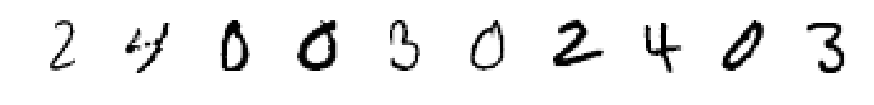

P1-CW: 


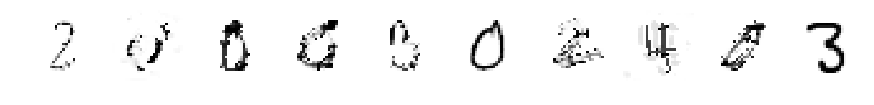

P2-CW: 


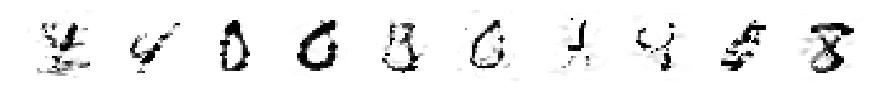

P2-FGSM: 


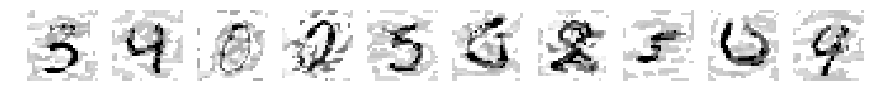

P2-BIM-A


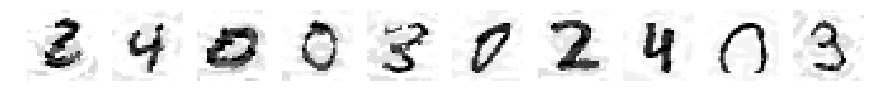

P2-BIM-B


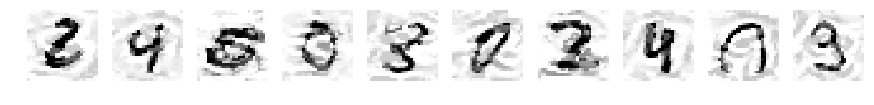

In [34]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,int(num_test_samples/2)), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10,)
print ('P1-CW: ')
visualize(p1_cw_data[x_vis].reshape(-1,*input_shape), 10, '../figures/p1-cw-cifar2')
print ('P2-CW: ')
visualize(p2_cw_data[x_vis].reshape(-1,*input_shape), 10, '../figures/p2-cw-cifar2')
print ('P2-FGSM: ')
visualize(p2_cw_fgsm_data[x_vis].reshape(-1,*input_shape), 10, '../figures/p2-fgsm-cifar2')
print ('P2-BIM-A')
visualize(p2_cw_bim_a_data[x_vis].reshape(-1,*input_shape), 10, '../figures/p2-bim-a-cifar2')
print ('P2-BIM-B')
visualize(p2_cw_bim_b_data[x_vis].reshape(-1,*input_shape), 10, '../figures/p2-bim-b-cifar2')


In [35]:
#Get predictions
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))
p2_cw_fgsm_preds = model.model.predict(p2_cw_fgsm_data.reshape(-1,*input_shape))
p2_cw_bim_a_preds = model.model.predict(p2_cw_bim_a_data.reshape(-1,*input_shape))
p2_cw_bim_b_preds = model.model.predict(p2_cw_bim_b_data.reshape(-1,*input_shape))


In [36]:
#Convert preds to labels
p1_cw_labels = preds_to_labels(p1_cw_preds)
p2_cw_labels = preds_to_labels(p2_cw_preds)
p2_cw_fgsm_labels = preds_to_labels(p2_cw_fgsm_preds)
p2_cw_bim_a_labels = preds_to_labels(p2_cw_bim_a_preds)
p2_cw_bim_b_labels = preds_to_labels(p2_cw_bim_b_preds)



In [37]:
#Check which points are actually adversarial and select those
p1_cw_idx = np.where(np.argmax(p1_cw_preds, axis=1) != true_preds)[0]
p2_cw_idx = np.where(np.argmax(p2_cw_preds, axis=1) != true_preds)[0]
p2_cw_fgsm_idx = np.where(np.argmax(p2_cw_fgsm_preds, axis=1) != true_preds)[0]
p2_cw_bim_a_idx = np.where(np.argmax(p2_cw_bim_a_preds, axis=1) != true_preds)[0]
p2_cw_bim_b_idx = np.where(np.argmax(p2_cw_bim_b_preds, axis=1) != true_preds)[0]

#Filter data points to be used for similarity
p1_cw_data_fil = p1_cw_data[p1_cw_idx]
p2_cw_data_fil = p2_cw_data[p2_cw_idx]
p2_cw_fgsm_data_fil = p2_cw_fgsm_data[p2_cw_fgsm_idx]
p2_cw_bim_a_data_fil = p2_cw_bim_a_data[p2_cw_bim_a_idx]
p2_cw_bim_b_data_fil = p2_cw_bim_b_data[p2_cw_bim_b_idx]

#Filter labels to be used
p1_cw_labels_fil = p1_cw_labels[p1_cw_idx]
p2_cw_labels_fil = p2_cw_labels[p2_cw_idx]
p2_cw_fgsm_labels_fil = p2_cw_fgsm_labels[p2_cw_fgsm_idx]
p2_cw_bim_a_labels_fil = p2_cw_bim_a_labels[p2_cw_bim_a_idx]
p2_cw_bim_b_labels_fil = p2_cw_bim_b_labels[p2_cw_bim_b_idx]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


In [38]:
#Get distortion (Prints nan if no sample was adversarial)
print ('P1-CW: %.5f' % (avg_l2_dist(reg_data[p1_cw_idx], p1_cw_data_fil)))
print ('P2-CW: %.5f' % (avg_l2_dist(reg_data[p2_cw_idx], p2_cw_data_fil)))
print ('P2-CW FGSM: %.5f' % (avg_l2_dist(reg_data[p2_cw_fgsm_idx], p2_cw_fgsm_data_fil)))
print ('P2-CW BIM A: %.5f' % (avg_l2_dist(reg_data[p2_cw_bim_a_idx], p2_cw_bim_a_data_fil)))
print ('P2-CW BIM B: %.5f' % (avg_l2_dist(reg_data[p2_cw_bim_b_idx], p2_cw_bim_b_data_fil)))

P1-CW: 6.17501
P2-CW: 4.13114
P2-CW FGSM: 9.79985
P2-CW BIM A: 10.85803
P2-CW BIM B: 10.99138


In [39]:
#Get cosine similarity and norms
grads_p1_cw_norms, cos_sim_p1_cw = norms_and_cos(model, p1_cw_data_fil, p1_cw_labels_fil, grads_train)
grads_p2_cw_norms, cos_sim_p2_cw = norms_and_cos(model, p2_cw_data_fil, p2_cw_labels_fil, grads_train)
grads_p2_cw_fgsm_norms, cos_sim_p2_cw_fgsm = norms_and_cos(model, p2_cw_fgsm_data_fil, p2_cw_fgsm_labels_fil, grads_train)
grads_p2_cw_bim_a_norms, cos_sim_p2_cw_bim_a = norms_and_cos(model, p2_cw_bim_a_data_fil, p2_cw_bim_a_labels_fil, grads_train)
grads_p2_cw_bim_b_norms, cos_sim_p2_cw_bim_b = norms_and_cos(model, p2_cw_bim_b_data_fil, p2_cw_bim_b_labels_fil, grads_train)

**THRESHOLDING FOR WHITEBOX**

In [40]:
#Ratio of perturbed samples having cos sim smaller

print ('1 Phase CW:  %.4f' % ( comp_cos(cos_sim_p1_cw, cos_sim_reg[p1_cw_idx])))
print ('2 Phase CW:  %.4f' % ( comp_cos(cos_sim_p2_cw, cos_sim_reg[p2_cw_idx])))
print ('2 Phase CW FGSM:  %.4f' % ( comp_cos(cos_sim_p2_cw_fgsm, cos_sim_reg[p2_cw_fgsm_idx])))
print ('2 Phase CW BIM A:  %.4f' % ( comp_cos(cos_sim_p2_cw_bim_a, cos_sim_reg[p2_cw_bim_a_idx])))
print ('2 Phase CW BIM B:  %.4f' % ( comp_cos(cos_sim_p2_cw_bim_b, cos_sim_reg[p2_cw_bim_b_idx])))


1 Phase CW:  0.0637
2 Phase CW:  0.0000
2 Phase CW FGSM:  0.0000
2 Phase CW BIM A:  0.0000
2 Phase CW BIM B:  0.0000


In [41]:
#Ratio of perturbed samples having norm greater

print ('1 Phase CW: %.4f' % ( comp_norm(grads_p1_cw_norms, grads_reg_norms[p1_cw_idx])))
print ('2 Phase CW: %.4f' % ( comp_norm(grads_p2_cw_norms, grads_reg_norms[p2_cw_idx])))
print ('2 Phase CW FGSM: %.4f' % ( comp_norm(grads_p2_cw_fgsm_norms, grads_reg_norms[p2_cw_fgsm_idx])))
print ('2 Phase CW BIM A: %.4f' % ( comp_norm(grads_p2_cw_bim_a_norms, grads_reg_norms[p2_cw_bim_a_idx])))
print ('2 Phase CW BIM B: %.4f' % ( comp_norm(grads_p2_cw_bim_b_norms, grads_reg_norms[p2_cw_bim_b_idx])))


1 Phase CW: 0.9554
2 Phase CW: 1.0000
2 Phase CW FGSM: 1.0000
2 Phase CW BIM A: 1.0000
2 Phase CW BIM B: 1.0000


In [42]:
#Separate Using Cos Sim
print ('REG:  %.4f' % ( greater_cos(cos_sim_reg, eta)))
print ('1 Phase CW:  %.4f' % ( greater_cos(cos_sim_p1_cw, eta)))        
print ('2 Phase CW:  %.4f' % ( greater_cos(cos_sim_p2_cw, eta)))
print ('2 Phase CW FGSM:  %.4f' % ( greater_cos(cos_sim_p2_cw_fgsm, eta)))       
print ('2 Phase CW BIM-A:  %.4f' % ( greater_cos(cos_sim_p2_cw_bim_a, eta)))      
print ('2 Phase CW BIM-B:  %.4f' % ( greater_cos(cos_sim_p2_cw_bim_b, eta)))



REG:  0.8650
1 Phase CW:  0.1248
2 Phase CW:  0.0000
2 Phase CW FGSM:  0.0000
2 Phase CW BIM-A:  0.0000
2 Phase CW BIM-B:  0.0000


In [43]:
#Separate using just norm
print ('Regular: %.4f' % ( smaller_norm(grads_reg_norms, gamma)))
print ('1 Phase CW:  %.4f' % ( smaller_norm(grads_p1_cw_norms, gamma)))        
print ('2 Phase CW:  %.4f' % ( smaller_norm(grads_p2_cw_norms, gamma)))
print ('2 Phase CW FGSM:  %.4f' % ( smaller_norm(grads_p2_cw_fgsm_norms, gamma)))       
print ('2 Phase CW BIM-A:  %.4f' % ( smaller_norm(grads_p2_cw_bim_a_norms, gamma)))      
print ('2 Phase CW BIM-B:  %.4f' % ( smaller_norm(grads_p2_cw_bim_b_norms, gamma)))

Regular: 0.8560
1 Phase CW:  0.0994
2 Phase CW:  0.0000
2 Phase CW FGSM:  0.0000
2 Phase CW BIM-A:  0.0000
2 Phase CW BIM-B:  1.0000


In [44]:
#Use both cos and norm
print ('Regular: %.4f' % ( cos_and_norm_sep(cos_sim_reg, grads_reg_norms, eta, gamma)))
print ('1 Phase CW: %.4f' % ( cos_and_norm_sep(cos_sim_p1_cw, grads_p1_cw_norms, eta, gamma)))
print ('2 Phase CW: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw, grads_p2_cw_norms, eta, gamma)))
print ('2 Phase CW FGSM: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw_fgsm, grads_p2_cw_fgsm_norms, eta, gamma)))
print ('2 Phase CW BIM A: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw_bim_a, grads_p2_cw_bim_a_norms, eta, gamma)))
print ('2 Phase CW BIM B: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw_bim_b, grads_p2_cw_bim_b_norms, eta, gamma)))

Regular: 0.7680
1 Phase CW: 0.0497
2 Phase CW: 0.0000
2 Phase CW FGSM: 0.0000
2 Phase CW BIM A: 0.0000
2 Phase CW BIM B: 0.0000


In [66]:
fgsm_dict = dict()
bim_a_dict = dict()
bim_b_dict = dict()
jsma_dict = dict()
cw_dict = dict()
df_dict = dict()

fgsm_ct = bim_a_ct = bim_b_ct = jsma_ct = cw_ct = df_ct = 0

for i in range(num_test_samples):
    if i in fgsm_idx:
        fgsm_dict[i] = fgsm_ct
        fgsm_ct+=1
    if i in bim_a_idx:
        bim_a_dict[i] = bim_a_ct
        bim_a_ct+=1
    if i in bim_b_idx:
        bim_b_dict[i] = bim_b_ct
        bim_b_ct+=1
    if i in cw_idx:
        cw_dict[i] = cw_ct
        cw_ct+=1
    if i in jsma_idx:
        jsma_dict[i] = jsma_ct
        jsma_ct+=1
    if i in df_idx:
        df_dict[i] = df_ct
        df_ct+=1

In [67]:
#Calculate points that were misclassified for all attacks
attacks = [fgsm_idx, bim_a_idx, bim_b_idx, cw_idx, jsma_idx, df_idx]
intersection = np.arange(num_test_samples)
for attack in attacks:
    intersection = np.intersect1d(intersection, attack)

In [70]:
#Get indices to access cos and norm matrices
fgsm_int = list()
bim_a_int = list()
bim_b_int = list()
jsma_int = list()
cw_int = list()
df_int = list()

#We plot 250 random points
num_indices = np.arange(250)
random_int = np.random.choice(intersection, 250)

for i in random_int:
    fgsm_int.append(fgsm_dict[i])
    bim_a_int.append(bim_a_dict[i])
    bim_b_int.append(bim_b_dict[i])
    cw_int.append(cw_dict[i])
    jsma_int.append(jsma_dict[i])
    df_int.append(df_dict[i])
    

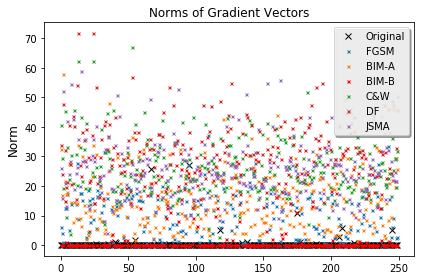

In [84]:
plt.plot(num_indices, grads_reg_norms[random_int], 'x', label='Original', ms=6, color='black')
plt.plot(num_indices, grads_fgsm_norms[fgsm_int], 'x', label='FGSM', ms=3)
plt.plot(num_indices, grads_bim_a_norms[bim_a_int], 'x', label='BIM-A', ms=3)
plt.plot(num_indices, grads_bim_b_norms[bim_b_int], 'x', label='BIM-B', ms=3, color='red')
plt.plot(num_indices, grads_cw_norms[cw_int], 'x', label='C&W', ms=3)
plt.plot(num_indices, grads_df_norms[df_int], 'x', label='DF', ms=3)
plt.plot(num_indices, grads_jsma_norms[jsma_int], 'x', label='JSMA', ms=3)
#plt.xlabel('Transformed', fontsize=12)
plt.ylabel('Norm', fontsize=12)
plt.title('Norms of Gradient Vectors')
plt.legend(loc="upper right", fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig('mnist_norm.eps', format='eps', dpi=1000)
plt.show()

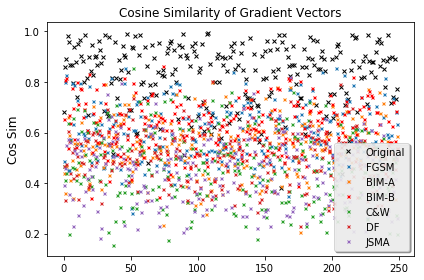

In [83]:
plt.plot(num_indices, np.max(cos_sim_reg[random_int], axis=1), 'x', label='Original', ms=4, color='black')
plt.plot(num_indices, np.max(cos_sim_fgsm[fgsm_int], axis=1), 'x', label='FGSM', ms=3)
plt.plot(num_indices, np.max(cos_sim_bim_a[bim_a_int], axis=1), 'x', label='BIM-A', ms=3)
plt.plot(num_indices, np.max(cos_sim_bim_b[bim_b_int], axis=1), 'x', label='BIM-B', ms=3, color='red')
plt.plot(num_indices, np.max(cos_sim_cw[cw_int], axis=1), 'x', label='C&W', ms=3)
plt.plot(num_indices, np.max(cos_sim_df[df_int], axis=1), 'x', label='DF',ms=3)
plt.plot(num_indices, np.max(cos_sim_jsma[jsma_int], axis=1), 'x', label='JSMA',ms=3)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
         # fancybox=True, shadow=True, ncol=3)
#plt.xlabel('Transformed', fontsize=12)
plt.ylabel('Cos Sim', fontsize=12)
plt.title('Cosine Similarity of Gradient Vectors')
plt.legend(loc="lower right", fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig('mnist_cos.eps', format='eps', dpi=1000)
plt.show()